In [1]:
!pip list

Package                  Version
------------------------ ---------
-yyaml                   5.1.2
absl-py                  0.8.0
altair                   4.1.0
altgraph                 0.17
appdirs                  1.4.3
argon2-cffi              20.1.0
arrow                    0.15.4
asgiref                  3.2.3
asn1crypto               1.0.1
astor                    0.8.0
astunparse               1.6.2
attrs                    19.2.0
Automat                  0.7.0
backcall                 0.1.0
backports.weakref        1.0rc1
base58                   2.0.1
bcrypt                   3.1.7
beautifulsoup4           4.8.1
bleach                   3.1.0
blinker                  1.4
blis                     0.4.1
bokeh                    2.0.2
boto                     2.49.0
boto3                    1.10.14
botocore                 1.17.12
branca                   0.3.1
cachetools               4.1.0
catalogue                1.0.0
certifi                  2019.9.11
cffi                   

In [2]:
import music21 as m21
import os
import json
import numpy as np
import keras

Using TensorFlow backend.
C:\Users\Lenovo\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Lenovo\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Lenovo\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Lenovo\anaconda3\lib\site-packages\tensorflow\python\framework\dtype

In [3]:
def load_songs_in_kern(path):
    songs = []
    for path, subdirs, files in os.walk(path):
        for file in files:
            if file[-3:]=='krn':
                song = m21.converter.parse(os.path.join(path, file))
                songs.append(song)
    return songs

In [4]:
PATH = "C:/Users/Lenovo/Desktop/New folder/python/Song Generation/deutschl/erk"
ACCEPTABLE_DURATIONS = [
    0.25,
    0.5,
    0.75,
    1,
    1.5,
    2,
    3,
    4
]
SAVE_DIR = "C:/Users/Lenovo/Desktop/New folder/python/Song Generation/dataset"
SINGLE_FILE_DATASET = "C:/Users/Lenovo/Desktop/New folder/python/Song Generation/file_dataset"
MAPPING_PATH = "C:/Users/Lenovo/Desktop/New folder/python/Song Generation/mapping.json"
SEQUENCE_LENGTH = 64

In [5]:
def has_acceptable_durations(song, acceptable_durations):
    for note in song.flat.notesAndRests:
        if note.duration.quarterLength not in acceptable_durations:
            return False
    return True

In [6]:
def transpose(song):
    # get key from the song
    parts = song.getElementsByClass(m21.stream.Part)
    measures_part_0 = parts[0].getElementsByClass(m21.stream.Measure)
    key = measures_part_0[0][4]
    
    # estimate key using music21
    if not isinstance(key, m21.key.Key):
        key = song.analyze("key")
        
    print(key)
    
    # get interval for transposition(eg BMajor => CMajor)
    if key.mode == "major":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("C"))
    elif key.mode == "minor":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("A"))
    
    # transpose song by calculated interval
    transposed_song = song.transpose(interval)
    
    return transposed_song

In [7]:
def encode_song(song, time_step = 0.25):
    # eg: p(pitch) = 60, d(duration) = 1.0 => encoded => [60, '_', '_', '_']
    encoded_song = []
    for event in song.flat.notesAndRests:
        # Notes
        if isinstance(event, m21.note.Note):
            symbol = event.pitch.midi  # 60
        # Rests
        elif isinstance(event, m21.note.Rest):
            symbol = "r"
        
        # convert into time/series representation
        steps = int(event.duration.quarterLength/time_step)
        for step in range(steps):
            if step==0:
                encoded_song.append(symbol)
            else:
                encoded_song.append("_")
    
    # Cast the encoded song to a string
    encoded_song = " ".join(map(str, encoded_song))
    return encoded_song

In [8]:
def load(file_path):
    with open(file_path, 'r') as f:
        song = f.read()
    return song

In [9]:
def create_single_file_dataset(dataset_path, file_dataset_path, sequence_length):
    new_song_delimiter = "/ " * sequence_length
    
    # load encoded songs and add delimiters
    songs = ""
    for path, _, files in os.walk(dataset_path):
        for file in files:
            file_path = os.path.join(path, file)
            song = load(file_path)
            songs += song + " " + new_song_delimiter
            
    songs = songs[:-1]
    
    # save the string which contains all the datasets
    with open(file_dataset_path, "w") as f:
        f.write(songs)
    
    return songs

In [10]:
def preprocess(path):
    
    # Load the Folk Songs
    print("Loading Songs....")
    songs = load_songs_in_kern(path)
    print(f"Loaded {len(songs)} songs.")
    
    for i, song in enumerate(songs):
        # Filter songs not having the acceptable durations
        if not has_acceptable_durations(song, ACCEPTABLE_DURATIONS):
            continue
        
        # transpose song to CMaj/AMinor
        song = transpose(song)
        
        # encode the songs with music-time series representation
        encoded_song = encode_song(song)
        
        # Save the song to a text file
        save_path = os.path.join(SAVE_DIR, str(i))
        
        with open(save_path, "w") as f:
            f.write(encoded_song)

In [11]:
def create_mapping(songs, mapping_path):
    mappings = {}
    
    # identify the vocabulary
    songs = songs.split()
    vocab = list(set(songs))
    
    # create mapping
    for i, symbol in enumerate(vocab):
        mappings[symbol] = i
    
    # save vocabulary to a json file
    with open(mapping_path, "w") as f:
        json.dump(mappings, f, indent=4)

In [12]:
def convert_songs_to_int(songs):
    int_songs = []
    
    # load the mappings
    with open(MAPPING_PATH, "r") as f:
        mappings = json.load(f)
    
    # cast song string to a list
    songs = songs.split()

    # map songs to int
    for symbol in songs:
        int_songs.append(mappings[symbol])
    
    return int_songs

In [13]:
def generate_training_sequences(sequence_length):
    # [11, 12, 13, 14, ....], => (input1 = [11, 12] , target1 = [13]) ; (input2 = [12, 13], target2 = [14])
    # network => predict the next item in the time sequence, predict the next musical note given the historical melody
    # LSTM => able to understand memory wise the next event in melody given the historical melody as input
    
    # Load the songs and map them to intergers
    songs = load(SINGLE_FILE_DATASET)
    int_songs = convert_songs_to_int(songs)
    
    inputs = []
    targets = []
    
    # Generate the training sequences
    # sequences length = 64, total symbols = 100 => no of sequences = 100-64 = 36
    num_sequences = len(int_songs) - sequence_length
    for i in range(num_sequences):
        inputs.append(int_songs[i:i+sequence_length])
        targets.append(int_songs[i+sequence_length])
    
    # inputs => (no of sequences, sequence_length)
    
    # One-hot encode the sequences to deal with the categorical data
    # inputs get an extra dimension => inputs => (no of sequences, sequence_length, vocab_size) => 3D array
    vocab_size = len(set(int_songs))
    inputs = keras.utils.to_categorical(inputs, num_classes = vocab_size)
    targets = np.array(targets)
    
    return inputs, targets

In [14]:
a = m21.environment.UserSettings()
a.keys()

['directoryScratch',
 'lilypondPath',
 'lilypondVersion',
 'lilypondFormat',
 'lilypondBackend',
 'musicxmlPath',
 'midiPath',
 'graphicsPath',
 'vectorPath',
 'pdfPath',
 'braillePath',
 'musescoreDirectPNGPath',
 'showFormat',
 'writeFormat',
 'ipythonShowFormat',
 'autoDownload',
 'debug',
 'warnings',
 'localCorpusSettings',
 'localCorporaSettings',
 'manualCoreCorpusPath',
 'localCorpusPath']

In [15]:
a['musicxmlPath'] = 'C:/Program Files/MuseScore 3/bin/MuseScore3.exe'
a['musescoreDirectPNGPath'] = 'C:/Program Files/MuseScore 3/bin/MuseScore3.exe'

Loaded 1700 songs

Has Acceptable duration? True

F major


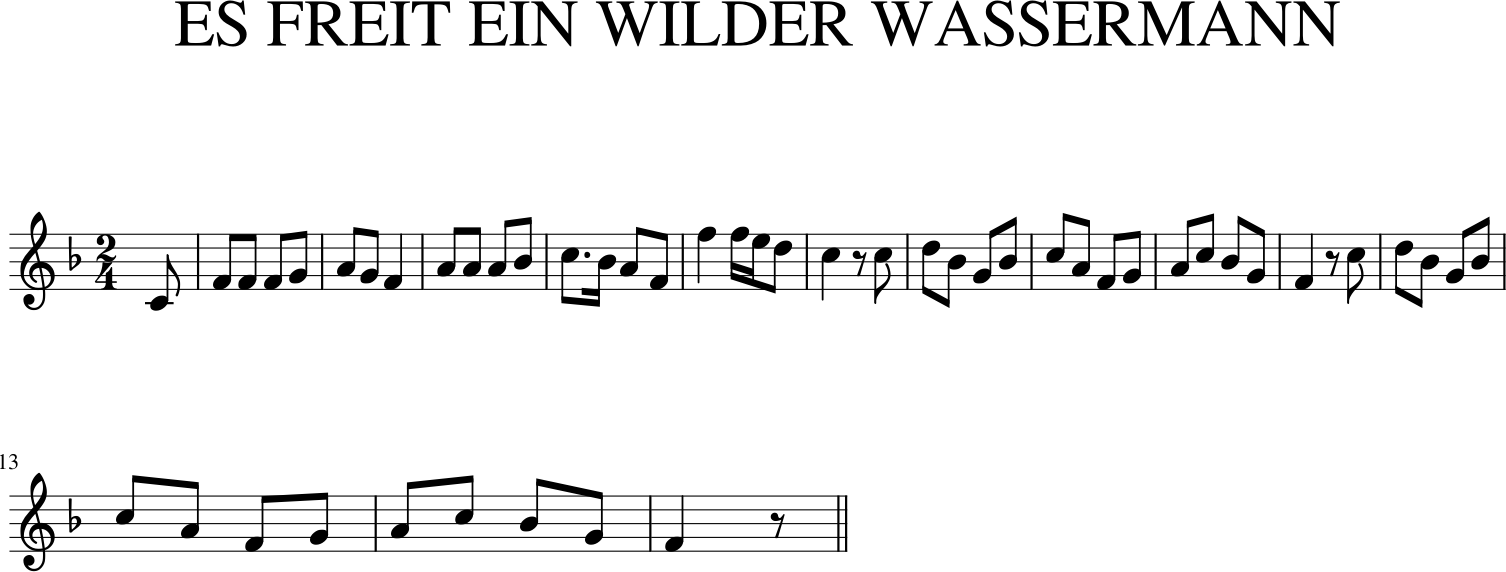

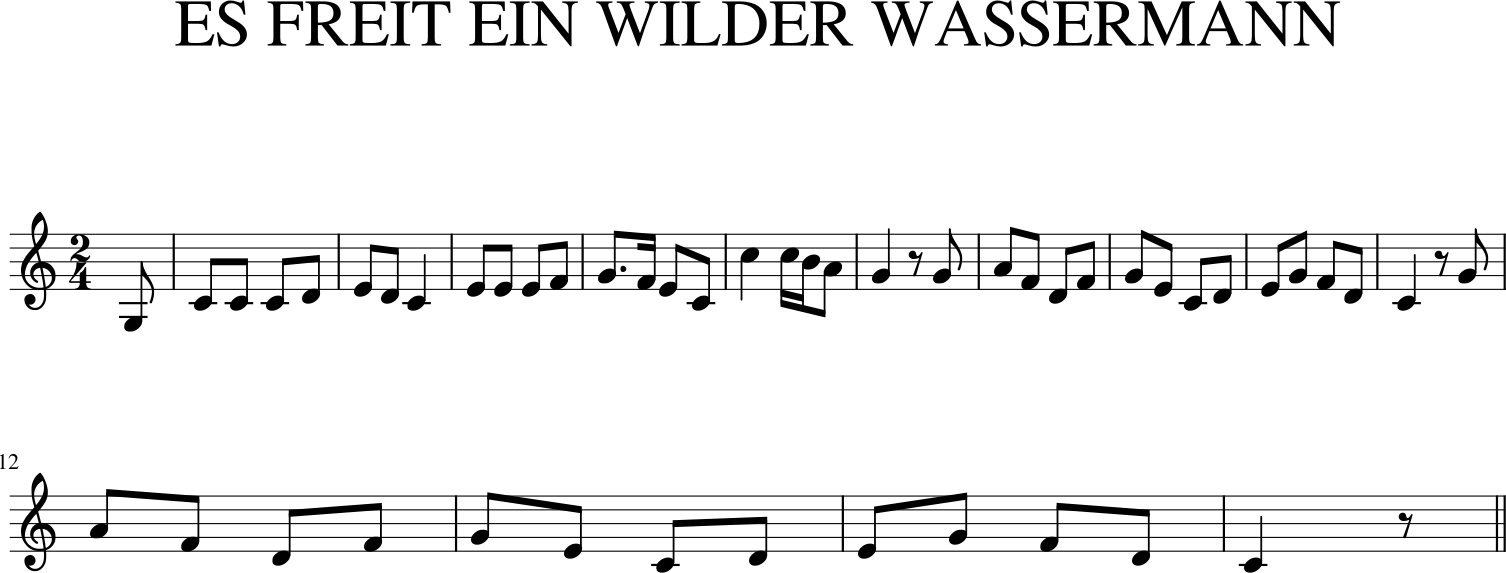

In [16]:
if __name__=="__main__":
    songs = load_songs_in_kern(PATH)
    print(f"Loaded {len(songs)} songs")
    song = songs[0]
    print()
    print(f"Has Acceptable duration? {has_acceptable_durations(song, ACCEPTABLE_DURATIONS)}")
    print()
    transposed_song = transpose(song)
    song.show()
    transposed_song.show()

In [17]:
def main():
    preprocess(PATH)
    songs = create_single_file_dataset(SAVE_DIR, SINGLE_FILE_DATASET, SEQUENCE_LENGTH)
    create_mapping(songs, MAPPING_PATH)
    inputs, targets = generate_training_sequences(SEQUENCE_LENGTH)
    print(inputs, targets)

In [18]:
if __name__=="__main__":
    main()

Loading Songs....
Loaded 1700 songs.
F major
F major
F major
F major
F major
G major
G major
A major
A major
F major
D major
G major
E- major
F major
G major
B- major
C major
G major
F major
C major
G major
A major
A major
G major
G major
G major
G major
a minor
G major
B- major
G major
G major
F major
E- major
B- major
B- major
F major
G major
C major
F major
F major
a minor
a minor
f minor
e minor
G major
G major
B- major
G major
G major
G major
G major
G major
G major
G major
F major
E- major
E- major
E- major
F major
C major
C major
C major
G major
F major
e minor
G major
A major
F major
F major
G major
G major
G major
G major
F major
G major
G major
G major
G major
G major
B- major
G major
G major
E- major
A major
G major
G major
G major
G major
f minor
G major
G major
G major
G major
G major
G major
g minor
G major
F major
D major
F major
F major
g minor
F major
F major
G major
D major
D major
D major
E- major
G major
G major
g minor
F major
F major
G major
G major
a minor
d mino